# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader


# Download Dataset

In [2]:
file={"username":"mojtabanafez","key":"7c0ebd541704e0cb4357c05f78ed5fa2"}
import json
with open('kaggle.json', 'w') as fp:
    json.dump(file, fp)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

100% 1.82G/1.83G [00:17<00:00, 58.0MB/s]
100% 1.83G/1.83G [00:17<00:00, 115MB/s] 


In [ ]:
# !gdown --id 1-8UrAsreTpYezl2z58xdg8v6ab2BbYmu

In [4]:
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

# Create Generator

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

TRAIN_DATA_PATH = "./car_data/car_data/train"
TEST_DATA_PATH = "./car_data/car_data/test"

TRANSFORM_IMG =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.Resize(size=(224,224)),
     ])
BATCH_SIZE=32
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 


In [6]:
len(train_data_loader), len(test_data_loader)

(255, 252)

In [7]:
dl=iter(train_data_loader)
x, y= next(dl)
x.shape, y.shape, torch.mean(x), torch.min(x), torch.max(x)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor(0.4517),
 tensor(0.),
 tensor(1.))

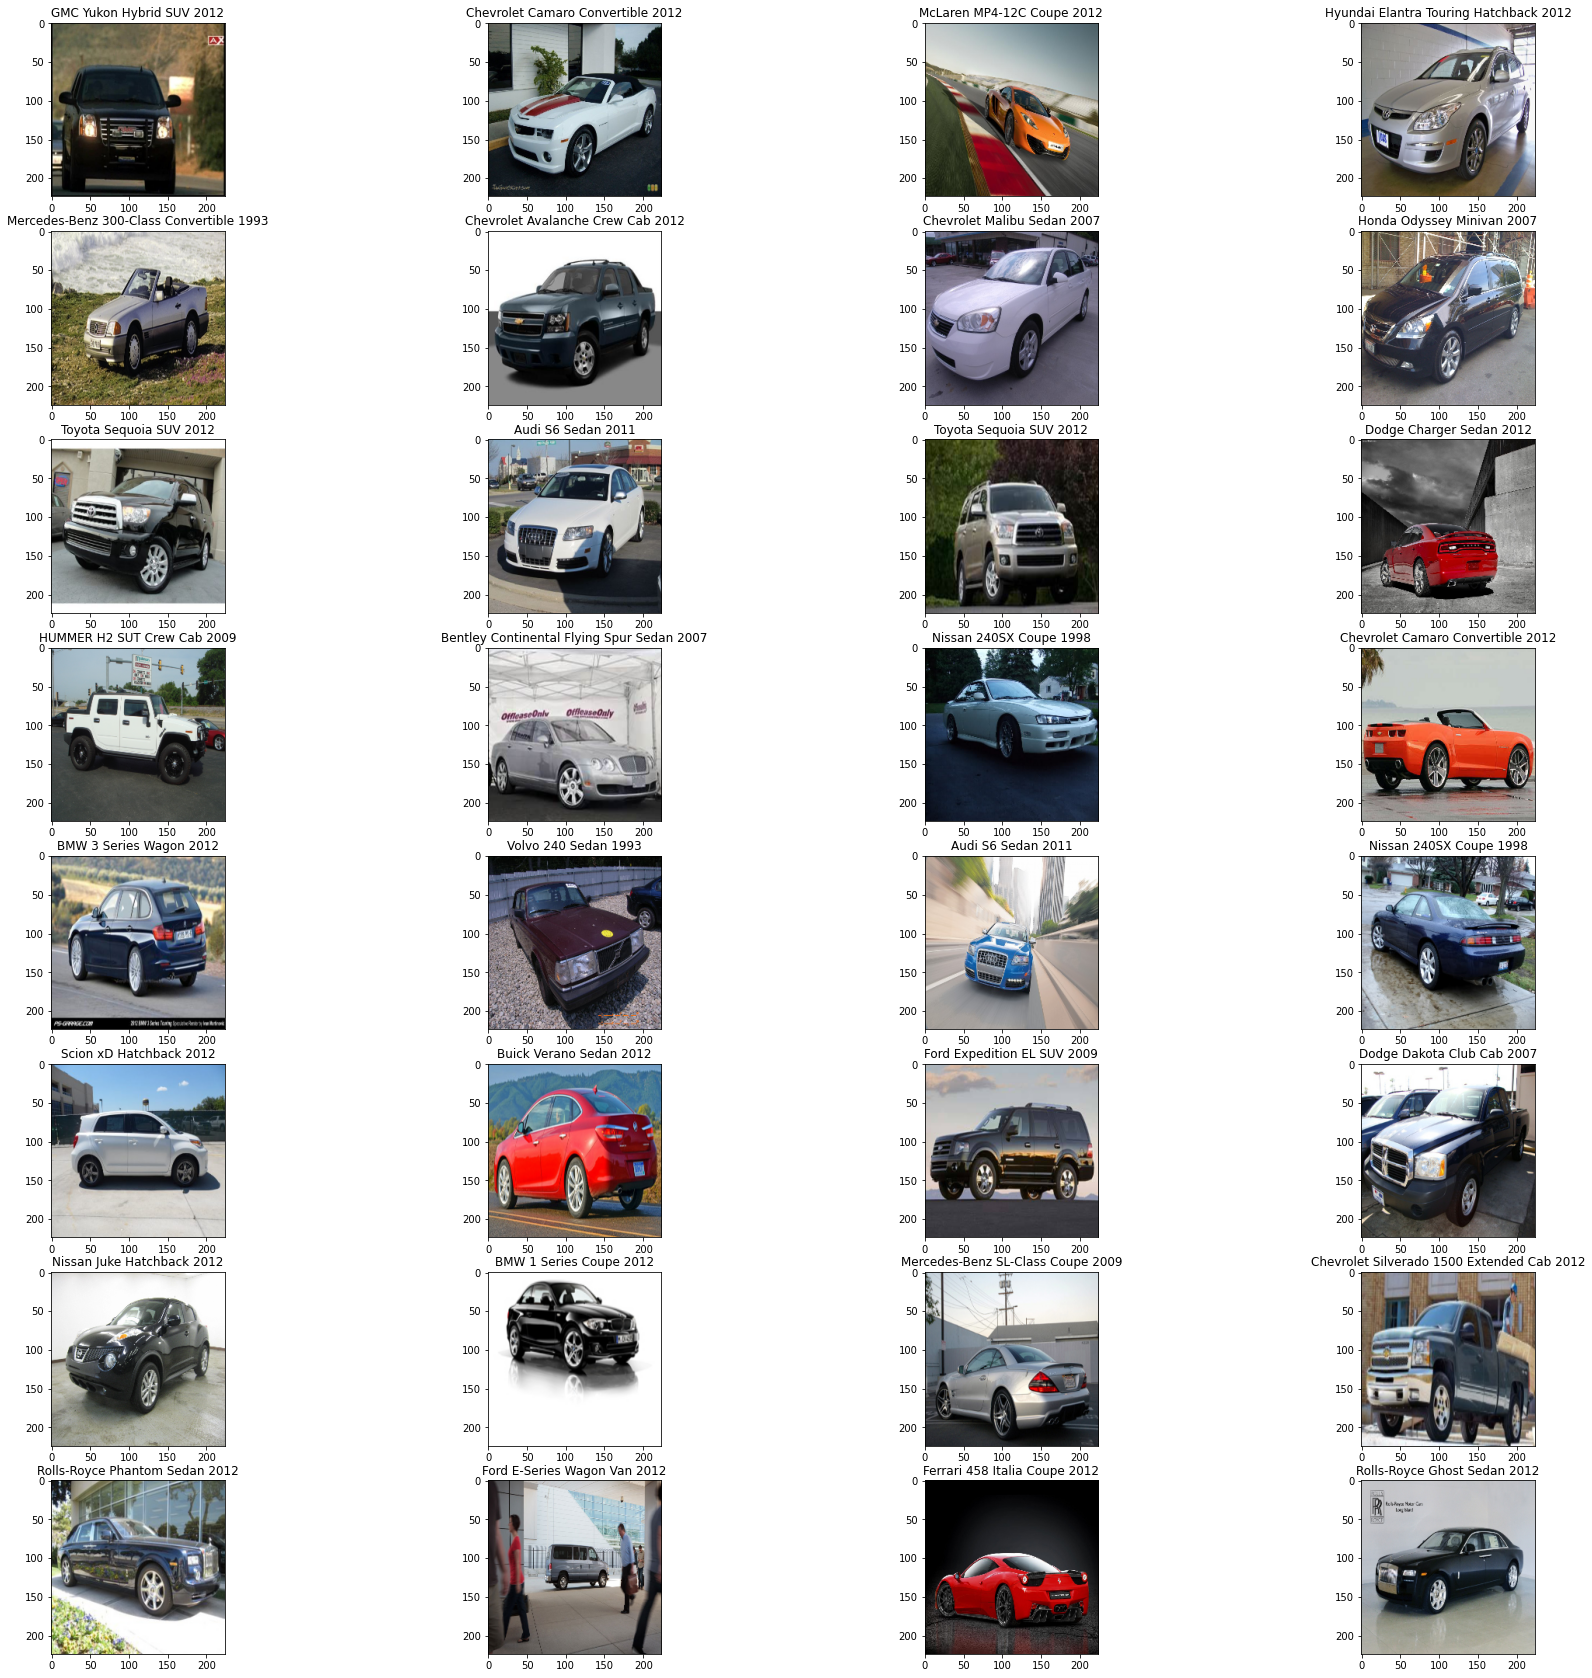

In [8]:
import numpy as np

classes = list(train_data.class_to_idx)


test_loader=iter(test_data_loader)
image, labels = test_loader.next()
image=np.array(image)
nrows=8
ncols=4
plt.figure (figsize = (30, 30))
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 1, 2))
for i in range(image.shape[0]):
    sp = plt.subplot(nrows, ncols, i+1)
    plt.imshow(image[i])
    plt.title(classes[int(labels[i])])
plt.show()
# print(image.shape, np.mean(image), np.max(image), np.min(image))

In [9]:
dataloaders={
    'train':train_data_loader,
    'val': test_data_loader
}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                current_corrects += torch.sum(preds == labels.data)            


            epoch_loss = 100/32 * current_loss / dataset_sizes[phase]
            # epoch_acc = current_corrects.double() / dataset_sizes[phase]
            epoch_acc = 100/32*current_corrects/dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
dataset_sizes

{'train': 255, 'val': 252}

In [23]:
class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.Linear(512, 256),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y
res_mod = models.resnet50(pretrained=True)
for p in res_mod.parameters():
    p.requires_grad = False
    
model = ResnetModel(res_mod, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

pytorch_total_params=  24738820
pytorch_total_trainable_params=  1230788


In [11]:
model

ResnetModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Changed
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)


Epoch 0/4
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 347.5444 Acc: 19.5466
Iterating through data...
val Loss: 329.8598 Acc: 22.0486

Epoch 1/4
----------
Iterating through data...
train Loss: 291.5554 Acc: 28.7623
Iterating through data...
val Loss: 322.4667 Acc: 25.1736

Epoch 2/4
----------
Iterating through data...
train Loss: 262.2366 Acc: 34.9142
Iterating through data...
val Loss: 320.1400 Acc: 26.5501

Epoch 3/4
----------
Iterating through data...
train Loss: 243.0891 Acc: 38.7010
Iterating through data...
val Loss: 287.1212 Acc: 32.1057

Epoch 4/4
----------
Iterating through data...
train Loss: 223.7831 Acc: 42.7206
Iterating through data...
val Loss: 312.2455 Acc: 30.6548

Training complete in 20m 40s
Best val Acc: 32.105656


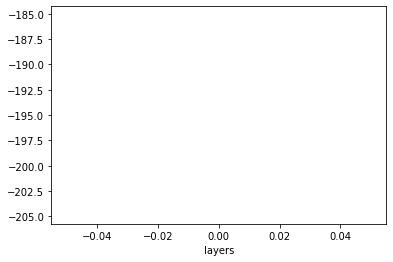

In [48]:
randInput = iter(train_data_loader)
x_sample, y_sample = next(randInput)
# GPU USAGE
x_sample = x_sample.to(device)

firstElement = x_sample[0]
sample = firstElement.reshape(1, 3, 224, 224)

sample = sample.to(device)
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook
model.register_forward_hook(get_features('feats'))
preds = model(sample)
  # placeholders
PREDS = []
FEATS = []
  
    # add feats and preds to lists
PREDS.append(preds.detach().cpu().numpy())
FEATS.append(features['feats'].cpu().numpy())

result = []
for i in range(len(FEATS)):
    result.append(len(FEATS[i]) - np.count_nonzero(FEATS[i])/len(FEATS[i]))
 
# plotting the points

plt.plot(result)
plt.xlabel('layers')
plt.show()

In [ ]:
x=0
for p in res_mod.parameters():
    if x > 140:
        p.requires_grad = True
    x += 1

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)